# OOPAO: The Python Legacy of OOMAO


The list of Adaptive Optics (AO) simulators in the community has constantly been growing, guided by different needs and purposes (Compass, HCIPY, OOMAO, SOAPY, YAO…). In this paper, we present OOPAO (Object Oriented Python Adaptive Optics), a simulation tool based on the Matlab distribution OOMAO to adapt its philosphy to the Python language. This code was initially intended for internal use but the choice was made to make it public as it can benefit the community since it is fully develloped in Python. The OOPAO repository is available in free access on GitHub ( https://github.com/cheritier/OOPAO) with several tutorials. 
The tool consists of a full end-to-end simulator designed for AO analysis purposes. The principle is that the light from a given light source can be propagated through multiple objects (Atmosphere, Telescope, Deformable Mirror, Wave-Front Sensors...) among which experimental features can be input, in the spirit of OOMAO.
This paper provides an overview of the current capabilities of the code and can be used as a user manuel for interested users.

## Getting started with OOPAO

The source code of OOPAO is available on GitHub https://github.com/cheritier/OOPAO. This page provides all the informations necessary to install the required packages. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import OOPAO



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             




# How To Use OOPAO
This section offers an overview of the main functionalities of the OOPAO code to present the philosophy of the code. 

## The Source Object
### Initialization
The source object carries the wavelength information as well as the flux information
It is initialized specifying the optical band and the magnitude of the star.  

In [2]:
from OOPAO.Source import Source
# to create a natural guide star in I band of magnitude 5
ngs = Source(magnitude = 5,
             optBand   ='I')


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 7.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 7.3e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



The optical bands are defined within the `Source` object inside the `photometry` method. 
The default photometry have been imported from the OOMAO toolkit. You can edit this function to add your own optical bands. 
```
                   [ Wavelength , Bandwidth, Zero-Point ]
        phot.U      = [ 0.360e-6 , 0.070e-6 , 2.0e12 ]
        phot.V      = [ 0.550e-6 , 0.090e-6 , 3.3e12 ]
        ...
```

### Properties
You can access a few properties of the ```ngs``` object: 

In [3]:
print('The source Wavelenght is '+str(ngs.wavelength) + ' [m] ')
print('The source Magnitude is '+str(ngs.magnitude))
print('The source Altitude is '+str(ngs.altitude) + ' [m] ')
print('The source Coordinates are '+str(ngs.coordinates) + ' [arcsec,deg] ')
print('The source Flux is '+str(ngs.nPhoton) + ' [phot/m2/s] ')
print('The source Type is '+str(ngs.type))
print('The source Tag is '+str(ngs.tag))

The source Wavelenght is 7.9e-07 [m] 
The source Magnitude is 5
The source Altitude is inf [m] 
The source Coordinates are [0, 0] [arcsec,deg] 
The source Flux is 73097826.08695652 [phot/m2/s] 
The source Type is NGS
The source Tag is source


The main properties of an OOPAO class can be displayed simply entering its name in a terminal.

## The Telescope Object
You can import the Telescope class from OOPAO using:

In [4]:
from OOPAO.Telescope import Telescope

The Telescope is a central object in OOPAO, it is required to initialize many of the OOPAO classes as it carries the pupil definition and pixel size.

A Source object is associated to the Telescope that carries the flux and wavelength information. 

An Atmosphere object can be paired to the Telescope to propagate the light through turbulent phase screens.

To initialize a Telescope object, you need to specify a few parameters, the diameter and the resolution of the telescope. The pixel size associated will define the pixel size of the phase-screens.

The sampling of the atmospheric phase screens is driven by different factors: 
- **Sampling of the Wave-Front Sensor sub-apertures:** the WFS object requires a resolution that is `n` times the number of subaperture where `n` should be an even number $>=$ 4.

- **Sampling of the turbulence:** It is recommanded to use at least 3 pixels per $r_0$, the Fried Parameter expressed at the wavelength of interest. 
- **Sampling of the influence functions of the Deformable Mirror:** Two pixels per influence functions is typically not enough and could lead to numerical errors when trying to apply a shape on the Deformable Mirror. 

In [5]:
# telescope parameters
sensing_wavelength = ngs.wavelength      # sensing wavelength of the WFS, read from the ngs object
n_subaperture      = 20                  # number of subaperture accross the diameter
diameter           = 8                   # diameter of the support of the phase screens in [m]
resolution         = n_subaperture*8     # resolution of the phase screens in pixels
pixel_size         = diameter/resolution # size of the pixels in [m]
obs_ratio          = 0.1                 # central obstruction in fraction of the telescope diameter
sampling_time      = 1/1000              # sampling time of the AO loop in [s]

# initialize the telescope object
tel = Telescope(diameter          = diameter,
               resolution         = resolution,
               centralObstruction = obs_ratio,
               samplingTime       = sampling_time)




------------ Telescope -------------
Diameter [m]             |   8.00   
Resolution [px]          |   160    
Pixel size [m]           |   0.05   
Surface [m²]             |   0.05   
Central obstruction [%]  |    10    
Pixels in pupil          |  19900   
Field of view [arcsec]   |   0.00   
------------------------------------



We can notice that, as indicated, so far no light is propagated through the telescope. See the section **Propagating light to the Telescope**


### Properties

A few properties of the `tel` object can be accessed:
* `tel.pupil` The pupil mask of the telescope
* `tel.pixelArea` The number of valid pixels in the pupil
* `tel.pupilReflectivity` User-defined pupil reflectivity (default: uniform)

### Methods
####  Apply spider to the pupils
You can defin a list of angle for each spider of the telescope. A spider is defined from the center to the edge of the pupil support. If necessqry, a shift offset can be applied to the spiders.


OOPAO Warning: 
A new pupil is now considered, its reflectivity is considered to be uniform. Assign the proper reflectivity map to tel.pupilReflectivity if required.
OOPAO Warning: 
Thickness is <=0, returning default pupil


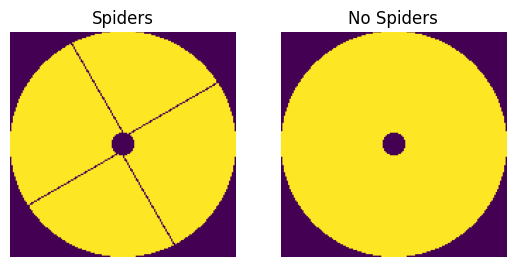

In [6]:
n_spider = 4
spider_angle = np.linspace(0+30,360+30,n_spider,endpoint=False)
tel.apply_spiders(spider_angle,thickness_spider=0.05,offset_X=[0.15,-0.15,-0.15,0.15],offset_Y=[0.15,0.15,-0.15,-0.15])
pupil_spiders =  tel.pupil.copy()
# reset to initial pupil
tel.apply_spiders(angle = [0],thickness_spider=0)
plt.subplot(1,2,1),plt.imshow(pupil_spiders),plt.axis('off'),plt.title('Spiders')
plt.subplot(1,2,2),plt.imshow(tel.pupil),plt.axis('off'),plt.title('No Spiders');

### Propagating light to the Telescope
#### Coupling a Source to the Telescope
To propagate the light of the Source through the Telescope, it is necessary to attach the `ngs` object to the `tel` object using the `*` operator.

In [7]:
ngs*tel


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 7.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 7.3e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

This time, the bottom part indicated that the NGS has been properly propagated to the telescope.
The optical path can be displayed using the `print_optical_path()` method 

In [8]:
tel.print_optical_path()
ngs.print_optical_path()

No light propagated through the telescope
NGS(I) ~~> telescope


The `tel` object now has an `src` attribute that corresponds to the `ngs` object


#### Flux properties
The flux properties are now adapted to the pupil of the telescope. 
The `tel.src` has a `fluxMap` property that displays a 2D map of the **number of photons per pixel per temporal iteration** 

#### Access the wave-front properties
The Optical Path Difference in [m] of the wave-front can be accessed using the `tel.OPD`

The Phase in [rad] wave-front can be accessed using the `ngs.phase` or the `tel.src.phase`


### Compute the PSF of the system

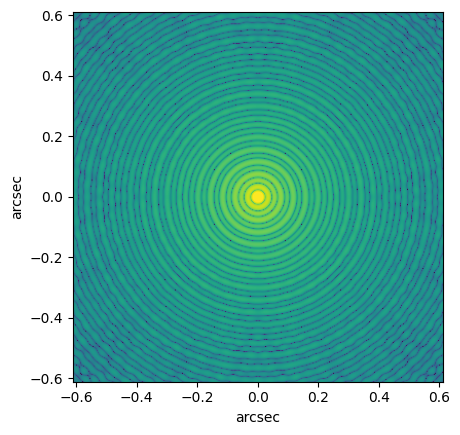

In [9]:
# set back the reflectivity 1
tel.pupilReflectivity = tel.pupil.astype(float)

# ngs*tel
ngs**tel #** instead of * to reset

# compute PSF method
zeroPaddingFactor = 6
tel.computePSF(zeroPaddingFactor=zeroPaddingFactor)

# get current pixel scale
size_pixel_arcsec = 206265*(tel.src.wavelength/tel.D)/zeroPaddingFactor
N                 = 300
normalized_PSF    = tel.PSF[N:-N,N:-N]# crop to zoom on the center
fov               = normalized_PSF.shape[0]*size_pixel_arcsec # get the corresponding fov
plt.imshow(np.log10(normalized_PSF),extent=[-fov/2,fov/2,-fov/2,fov/2])
plt.clim([-6,4]),plt.xlabel('arcsec'),plt.ylabel('arcsec');

## The Atmosphere Object
You can import the Telescope class from OOPAO using:

In [10]:
from OOPAO.Atmosphere import Atmosphere

An Atmosphere is made of one or several layer of turbulence that follow the Van Karmann statistics. Each layer is considered to be independant to the other ones and has its own properties (direction, speed, etc.)

The Atmosphere object can be defined for a single Source object (default) or multi Source Object (see Asterism class). The Source coordinates allow to span different areas in the field (defined as well by tel.fov).

If the source type is an LGS the cone effect is considered using an interpolation. 

NGS and LGS can be combined together in the Asterism object. 

The convention chosen is that all the wavelength-dependant atmosphere parameters are expressed at 500 nm. 


In [11]:
# setting a two layers atmosphere
atm = Atmosphere(telescope      = tel,
                 r0             = 0.15,
                 L0             = 25,
                 fractionalR0   = [0.7, 0.3  ],
                 altitude       = [0  , 10000],
                 windDirection  = [0  , 20   ],
                 windSpeed      = [5  , 10   ])

The atmosphere has to be initialized using the `atm.initializeAtmosphere()` command

In [12]:
atm.initializeAtmosphere(telescope=tel)

Creation of layer1/2 ...
-> Computing the initial phase screen...
initial phase screen : 0.02394866943359375 s
ZZt.. : 10.135438680648804 s
ZXt.. : 0.5560433864593506 s
XXt.. : 0.32657408714294434 s
Done!
Creation of layer2/2 ...
-> Computing the initial phase screen...
initial phase screen : 0.019665956497192383 s
ZZt.. : 9.5367431640625e-07 s
ZXt.. : 4.220008850097656e-05 s
XXt.. : 1.2874603271484375e-05 s
SCAO system considered: covariance matrices were already computed!
Done!
Updating the Atmosphere covariance matrices...

------------------------ Atmosphere -------------------------
 Layer | Direction | Speed | Altitude | Frac Cn² | Diameter |
       |    [°]    | [m/s] |   [m]    |   [%]    |   [m]    |
   1   |     0     |  5.0  |  0e+00   |    70    |  8.200   |
   2   |    20     | 10.0  |  1e+04   |    30    |  8.200   |
r0 @ 500 nm [m] |   0.15   
L0 [m]          |   25.0   
Tau0 [s]        |  0.0072  
V0 [m/s]        |   6.50   
Frequency [Hz]  |  1000.0  
-----------------

The `atm` layers can be displayed using the `atm.display_atm_layers()` command

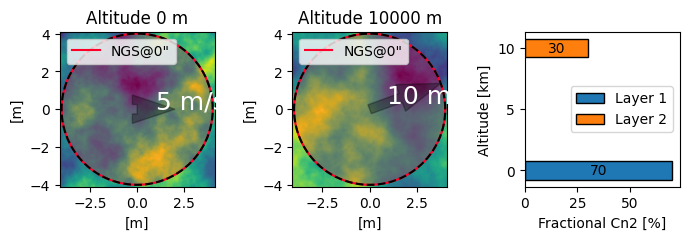

In [13]:
atm.display_atm_layers()

The atmosphere `atm` can be combined to the telescope using the `+`. In that case, the OPD of the telescope is copied from the atmosphere OPD:

Telescope and Atmosphere combined!
False
source

------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 7.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 7.3e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Telescope and Atmosphere separated!


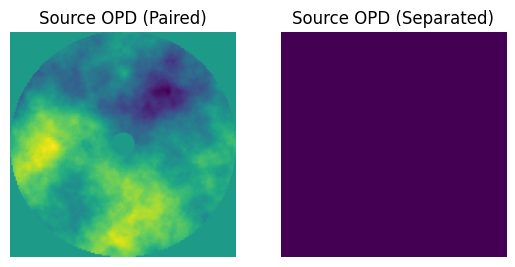

In [14]:
tel+atm
OPD_tel_paired = ngs.OPD.copy()
tel-atm
OPD_tel_separated = ngs.OPD.copy()
plt.subplot(1,2,1),plt.imshow(OPD_tel_paired),plt.axis('off'),plt.title('Source OPD (Paired)')
plt.subplot(1,2,2),plt.imshow(OPD_tel_separated),plt.axis('off'),plt.title('Source OPD (Separated)');

# Deformable Mirror


The deformable mirror is mainly characterized with its influence functions. They can be user-defined and loaded in the model but the default case is a cartesian DM with gaussian influence functions and normalized to 1 [m]. 
The DM is always defined in the pupil plane and can be conjugated to different altitude. 
### Fried-Geometry
By default, the Deformable Mirror geometry follows the Fried's definition where each actuator is located at the corner of 4 WFS sub-aperture. The number of sub-aperture is then a required parameter of the Deformable Mirror class. 

In [15]:
from OOPAO.DeformableMirror import DeformableMirror
mechanical_coupling = 0.45

dm_fried = DeformableMirror(  telescope    = tel,
                        nSubap       = n_subaperture, # by default n_subaperture+1 actuators are considered (Fried Geometry)
                        mechCoupling = mechanical_coupling)

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   356   
M4                       |  False  
Pitch [m]                |  0.40   
Mechnical coupling [%]   |   45    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



The DM commands can be applied as a linear combination of the influence functions `dm.modes` setting the `dm.coefs` property:

In [16]:
dm_fried.coefs = np.random.rand(dm_fried.nValidAct)

The light can be propagated through the telescope, passing by the deformable mirror using the `*` operator:


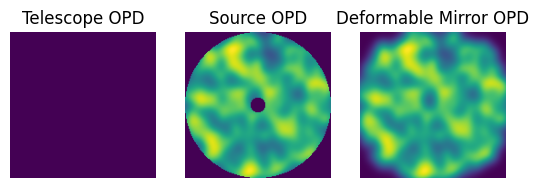

In [17]:
ngs**tel*dm_fried
plt.subplot(1,3,1),plt.imshow(tel.OPD),plt.axis('off'),plt.title('Telescope OPD')
plt.subplot(1,3,2),plt.imshow(ngs.OPD),plt.axis('off'),plt.title('Source OPD')
plt.subplot(1,3,3),plt.imshow(dm_fried.OPD),plt.axis('off'),plt.title('Deformable Mirror OPD');

### Mis-Registration
To apply a mis-registration

By default, the Deformable Mirror geometry follows the Fried's definition where each actuator is located at the corner of 4 WFS sub-aperture. The number of sub-aperture is then a required parameter of the Deformable Mirror class.


In [18]:
from OOPAO.MisRegistration import MisRegistration

m = MisRegistration()
m.shiftX = 0.05*tel.D/n_subaperture
m.shiftY = 0.1*tel.D/n_subaperture
m.rotationAngle = 15
m.radialScaling = 0.1
m.tangentialScaling = 0
m.anamorphosisAngle = 45

dm_mis_registered = DeformableMirror(  telescope    = tel,
                        nSubap       = n_subaperture, # by default n_subaperture+1 actuators are considered (Fried Geometry)
                        mechCoupling = mechanical_coupling,
                        misReg       = m)

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   356   
M4                       |  False  
Pitch [m]                |  0.40   
Mechnical coupling [%]   |   45    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



### User-defined geometry


In [19]:
# create a circular DM
n_ring = 11; n_start = 5; cx = []; cy = []
for i in range(1,n_ring+1):
    r = i*(tel.D/2)/(n_ring)
    theta = np.linspace(0,2*np.pi,n_start,endpoint=False)
    cx = np.hstack((cx,(r*np.cos(theta))))
    cy = np.hstack((cy,(r*np.sin(theta))))
    n_start += 6
# input coordinates must be provided in a 2D array [nAct,2]
circular_coordinates = np.vstack((cx,cy)).T
dm_circular = DeformableMirror(  telescope    = tel,
                        nSubap       = n_subaperture, # by default n_subaperture+1 actuators are considered (Fried Geometry)
                        mechCoupling = mechanical_coupling,coordinates=circular_coordinates)

Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   385   
M4                       |  False  
Pitch [m]                |  0.40   
Mechnical coupling [%]   |   45    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



### User-Defined influence functions


It is possible to input the influence functions of the DM directly. In this example, we consider a modal DM that corresponds to zernike polynomials. 


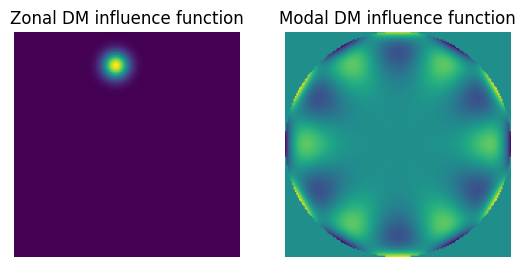

In [20]:
from OOPAO.Zernike import Zernike
Z = Zernike(tel,300) # create a Zernike object considering 300 polynomials
Z.computeZernike(tel) # compute the Zernike
Z_2D = Z.modesFullRes.reshape((tel.resolution**2,Z.nModes))# reshape the 3D cube in 2D for the dm class
dm_Zernike = DeformableMirror( telescope = tel,
                               nSubap    = n_subaperture, # keep it to n_subaperture ( required to apply mis-registrations)
                               modes     = Z_2D, print_dm_properties=False)
plt.subplot(1,2,1),plt.imshow(dm_fried.modes[:,40].reshape(tel.pupil.shape)),plt.axis('off'),plt.title('Zonal DM influence function')
plt.subplot(1,2,2),plt.imshow(dm_Zernike.modes[:,40].reshape(tel.pupil.shape)),plt.axis('off'),plt.title('Modal DM influence function');

We can display the cube of the influence functions to display the position of the actuators with respect to the pupil. 

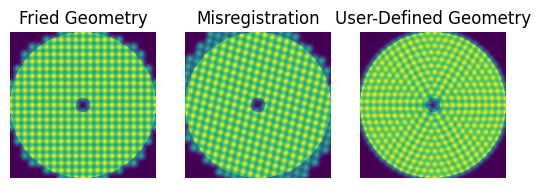

In [21]:
cube_IF_fried    = np.reshape(np.sum(dm_fried.modes**6,axis =1),[tel.resolution,tel.resolution])
cube_IF_mis_reg  = np.reshape(np.sum(dm_mis_registered.modes**6,axis =1),[tel.resolution,tel.resolution])
cube_IF_circular = np.reshape(np.sum(dm_circular.modes**6,axis =1),[tel.resolution,tel.resolution])

plt.subplot(1,3,1),plt.imshow(cube_IF_fried/cube_IF_fried.max() +0.5*tel.pupil),plt.axis('off'),plt.title('Fried Geometry')
plt.subplot(1,3,2),plt.imshow(cube_IF_mis_reg/cube_IF_mis_reg.max() +0.5*tel.pupil),plt.axis('off'),plt.title('Misregistration');
plt.subplot(1,3,3),plt.imshow(cube_IF_circular/cube_IF_circular.max() +0.5*tel.pupil),plt.axis('off'),plt.title('User-Defined Geometry');

# Wave-Front Sensors

## Pyramid WFS
The pyramid object consists mainly in defining the PWFS phase mask to apply the filtering of the electro-magnetic field. 
Many parameters can allow to tune the pyramid model:
* Number of pixels `nSubap` along the telescope pupil support. `tel.resolution` should be a multiple of `nSubap` and >=4 
* Cicular modulation radius in λ/D `modulation`. By default the number of modulation points ensures to have one point every λ/D on the circular trajectory but this sampling can be modified by the user. The number of modulation points is a multiple of 4 to ensure that each quadrant has the same number of modulation points. A user-defined modulation path can be input.
* The type of post-processing of the PWFS signals (slopes-maps, full-frame,etc). To be independent from this choice, the pyramid signals are named “wfs.signal_2D” for either the Slopes-Maps or the camera frame and `signal` for the signal reduced to the valid pixels considered.
* The intensity threshold to select the valid pixel 
* Centering of the mask and of the FFT on 1 or 4 pixels `psfCentering`
* Number of pixels separating the PWFS pupils `n_pix_separation`
* Number of pixels on the edge of the Pyramid pupils`n_pix_edge`
* The modulation value for the calibration and selection of the valid pixels `calibModulation` 

In addition, the Pyramid object has a Detector object as a child-class that provides the pyramid signals. It can be access through `pwfs.cam`

-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   60    
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   72    
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Pyramid Mask initialization...
Selection of the valid pixels...
The valid pixel are selected on flux considerations
Acquisition of the reference slopes and units calibration...
WFS calibrated!
False
source


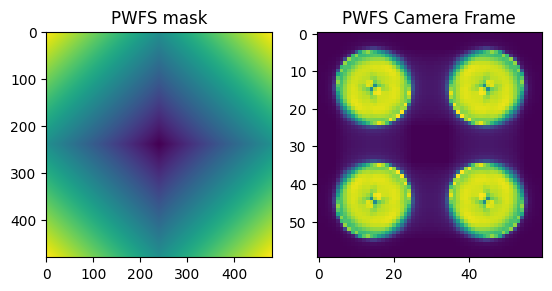

In [22]:
from OOPAO.Pyramid import Pyramid

pwfs = Pyramid(src              = ngs,
               telescope        = tel,
               nSubap           = n_subaperture,
               modulation       = 3,
               lightRatio       = 0.1,
               postProcessing   = 'slopesMaps',
               n_pix_separation = 10,
               n_pix_edge       = 5)

plt.figure(),
plt.subplot(1,2,1),plt.imshow(pwfs.m),plt.title('PWFS mask') # 2D phase mask
plt.subplot(1,2,2),plt.imshow(pwfs.cam.frame),plt.title('PWFS Camera Frame'); # camera detector frame

It is possible to shift the Pyramid pupils using the `apply_shift_wfs` method by applying an additional Tip/Tilt on each quadrant of the phase mask

OOPAO Warning: 
The Pyramid pupils have been shifted outside of the detector!Wrapping of the signal is currently occuring!!


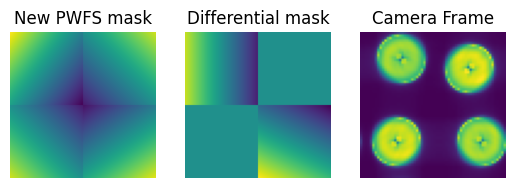

In [23]:
pwfs.apply_shift_wfs(sx=[5,0,2,0],sy=[0,0,4,0])
plt.figure(),
plt.subplot(1,3,1),plt.imshow(pwfs.m),plt.axis('off'), plt.title('New PWFS mask') # 2D phase mask
plt.subplot(1,3,2),plt.imshow(pwfs.m-pwfs.initial_m),plt.axis('off'), plt.title('Differential mask') # 2D phase mask
plt.subplot(1,3,3),plt.imshow(pwfs.cam.frame),plt.axis('off'), plt.title('Camera Frame'); # camera detector frame
# set it back to default
pwfs.apply_shift_wfs(sx=0,sy=0)


The focal plane electric field is accessible through the `modulation_camera_em` property. 
This is used by the `get_modulation_frame` method to compute the intensity in at the focal plane, afte the Tip/Tilt modulation mirror. The `radius` allows to select the field of view.

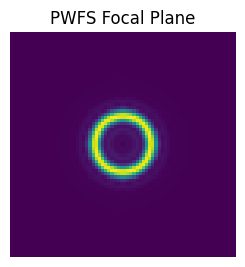

In [24]:
# acquire a frame with the focal plane camera
pwfs*pwfs.focal_plane_camera
plt.figure(),
plt.subplot(1,2,1),plt.imshow(pwfs.focal_plane_camera.frame)
plt.axis('off'), plt.title('PWFS Focal Plane'); # radius in lambda/D


## Shack Hartmann WFS

A Shack Hartmann object consists in defining a 2D grid of lenslet arrays located in the pupil plane of the telescope to estimate the local tip/tilt seen by each lenslet. 
By default the Shack Hartmann detector is considered to be noise-free (for calibration purposes). These properties can be switched on and off on the fly (see properties)
        It requires the following parameters: 

* The number of lenslets `nSubap` accross the support of the telescope pupil 
* The intensity threshold `lightRatio` to select the valid lenslets
* The flag `is_geometric` to switch from diffractive to geometric Shack Hartmann
* `shannon_sampling` to sample the diffractive spots with 2 pixels per lambd/D (`True`) or 1 pixel per lambda/D (`False`)
* theshold to compute the center of gravity `threshold_cog` with respect to the maximum value of the image



No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   160   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   20    
Subaperture Pitch [m]    |  0.40   
Subaperture FoV [arcsec] |  1.63   
Pixel Scale [arcsec]     |  0.204  
Valid Subapertures       |   624   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
-----------------------------------



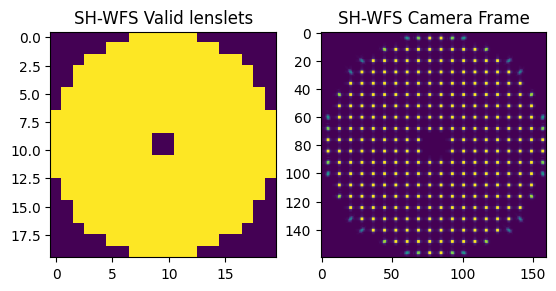

In [25]:
from OOPAO.ShackHartmann import ShackHartmann
shwfs = ShackHartmann(telescope    = tel,
                      src=ngs,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.5,
                      is_geometric       = False,
                      shannon_sampling   = True,
                      threshold_cog      = 0.1)
plt.figure(), 
plt.subplot(1,2,1),plt.imshow(shwfs.valid_subapertures),plt.title('SH-WFS Valid lenslets') # 2D phase mask
plt.subplot(1,2,2),plt.imshow(shwfs.cam.frame),plt.title('SH-WFS Camera Frame'); # camera detector frame

it is possible to switch from geometric to diffractive shack hartmann simply by setting `wfs.is_geometric` to `True` or `False`

In [26]:
# make sure that the telescope OPD is initiliazed
tel.resetOPD()
ngs*tel*shwfs
shwfs.is_geometric = True

False
source

------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 7.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 7.3e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Re-initializing WFS...
Acquiring reference slopes..
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done
OOPAO Warning: 
All Detector Noises are disables with the geometric WFS

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   20    
Subaperture Pitch [m]    |  0.40   
Subaperture FoV [arcsec] |  1.63   
Pixel Scale [arcsec]     |  0.204  
Valid Subapertures       |   624   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  True   
-----------------------------------



# Modal Basis
A few modal basis or available in OOPAO: Zernike and KL Modes.
## Zernike Polynomials

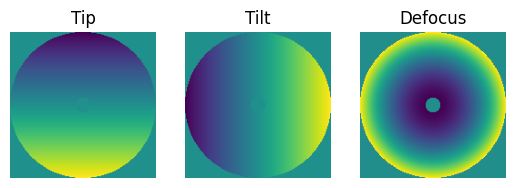

In [27]:
from OOPAO.Zernike import Zernike
Z = Zernike(tel,9)      # first initialize the Zernike object
Z.computeZernike(tel)   # compute the Zernike for the desired telescope
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(Z.modesFullRes[:,:,i]),plt.axis('off'), plt.title(Z.modeName(i));

The Zernike can be projected on the `dm`using the dm influence functions `modes` from the `dm` object

In [28]:
M2C_zernike = np.linalg.pinv(np.squeeze(dm_fried.modes[tel.pupilLogical,:]))@Z.modes

It is possible to display the modal basis using the `displayMap` function

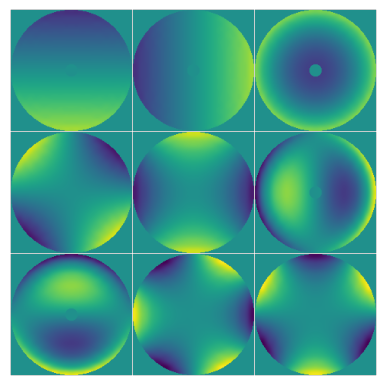

In [29]:
from OOPAO.tools.displayTools import displayMap
dm_fried.coefs = M2C_zernike[:,:9]
ngs**tel*dm_fried
displayMap(ngs.OPD)

## KL Modal Basis
A simplified function is available to provide KL modes orthogonal in the DM space, forcing the Tip/Tilt to be included in the Modal basis. 

A more detailed fonctions is available in the `compute_KL_modal_basis` if required.

In [30]:
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
M2C_KL = compute_KL_basis(src=ngs,tel=tel,atm=atm,dm=dm_fried)

TIME ELAPSED: 2 sec. COMPLETED: 100 %
NMAX =  300
RMS opd error = [[9.83402175e-09 1.53504061e-08 1.53504061e-08]]
RMS Positions = [[7.07072183e-08 3.20843572e-07 3.20843572e-07]]
MAX Positions = [[4.52512686e-07 7.98921236e-07 7.98921236e-07]]
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  3.439066418818864e-14


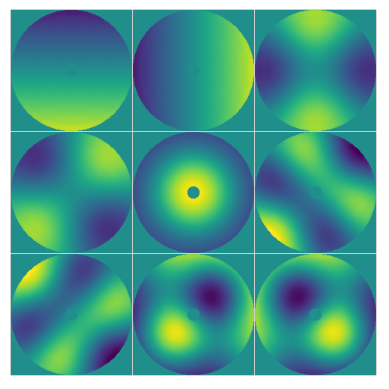

In [31]:
dm_fried.coefs = M2C_KL[:,:9]
ngs*tel*dm_fried
displayMap(ngs.OPD)

# Calibration
The measurement of the interaction matrix is done using the `InteractionMatrix` class

In [32]:
M2C_KL.shape

(356, 301)

In [33]:
tel.display_optical_path = False
from OOPAO.calibration.InteractionMatrix import InteractionMatrix

# modal interaction matrix
calib_modal = InteractionMatrix( ngs            = ngs,
                                 atm            = atm,                   
                                 tel            = tel,              
                                 dm             = dm_fried,         
                                 wfs            = shwfs,            
                                 M2C            = M2C_KL[:,:300],   # M2C matrix to use for the calibration
                                 stroke         = 1e-9,             # stroke for the calibration in [nm]
                                 nMeasurements  = 1,               # number of measurements in parallel
                                 noise          = 'off')         # enable noise during the calibration


The details of the pseudo inverse of the interaction matrix are accessible within the properties of `calib_modal`. 

The input matrix is denoted  `calib_modal.D` and its pseudo inverse  `calib_modal.M`. 

By default, no singular values are truncated in the pseudo inverse: 
$M = (D^T.D)^{-1}D^T$

It is possible to recompute `calib_modal.M` truncating singular values using the `calib_modal.nTrunc` property:

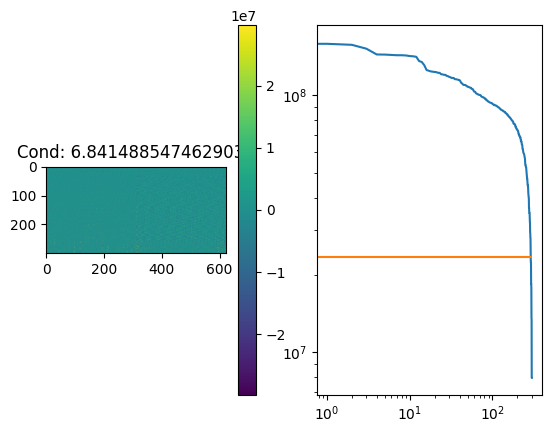

In [34]:
# truncate the 10 last singular values 
calib_modal.nTrunc = 10

## Reconstructing  a phase from WFS measurements
It is now possible to reconstruct a given phase using wfs measurements using the `calib_modal.M` matrix:



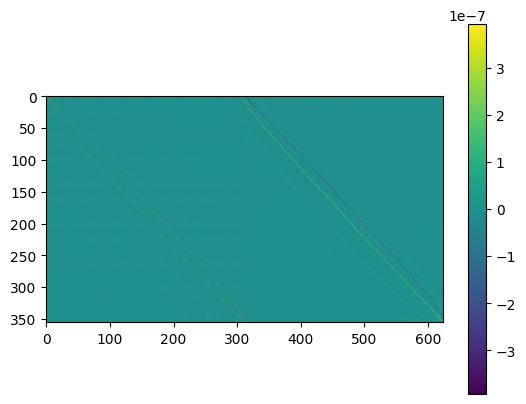

In [36]:
reconstructor = M2C_KL[:,:300]@calib_modal.M

plt.imshow(reconstructor)
plt.colorbar()

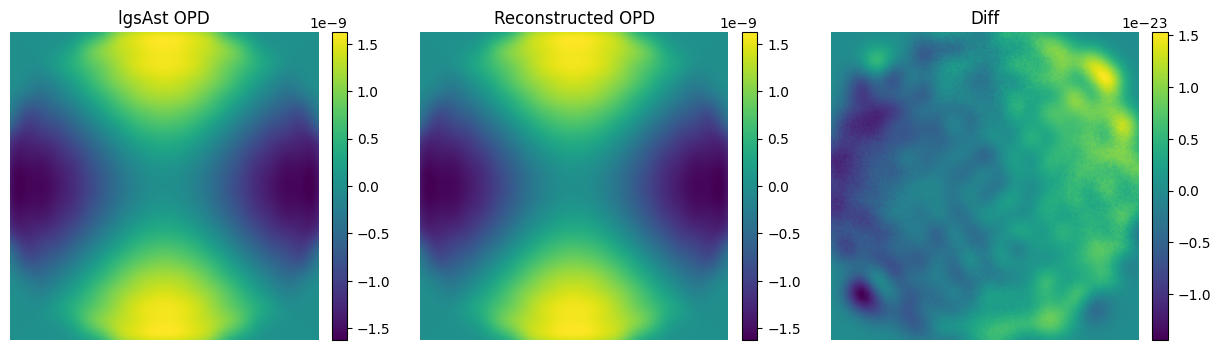

In [38]:
n = 2
input_modes = np.random.randn(1)*1e-9
dm_fried.coefs = M2C_KL[:,n] * input_modes

ngs**tel*dm_fried*shwfs
# shwfs.signal = np.hstack(shwfs.signal)

# reconstructor = calib_modal.M

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im = axes[0].imshow(ngs.OPD_no_pupil)
axes[0].axis('off')
axes[0].set_title(f'lgsAst OPD')
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

rec_OPD = (dm_fried.modes@reconstructor@shwfs.signal).reshape((tel.resolution, tel.resolution))


im = axes[1].imshow(rec_OPD)
axes[1].axis('off')
axes[1].set_title(f'Reconstructed OPD')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

im = axes[2].imshow(dm_fried.OPD-rec_OPD)
axes[2].axis('off')
axes[2].set_title(f'Diff')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)



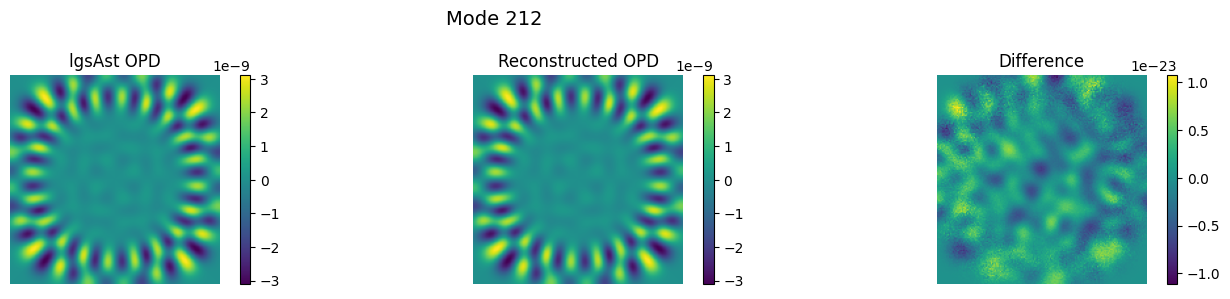

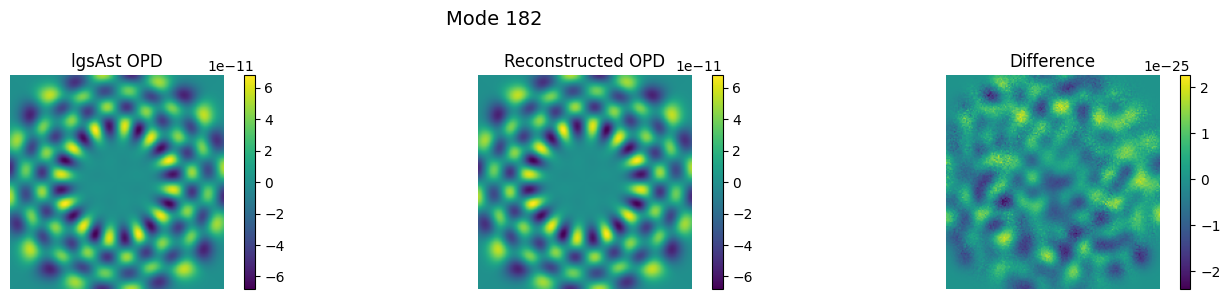

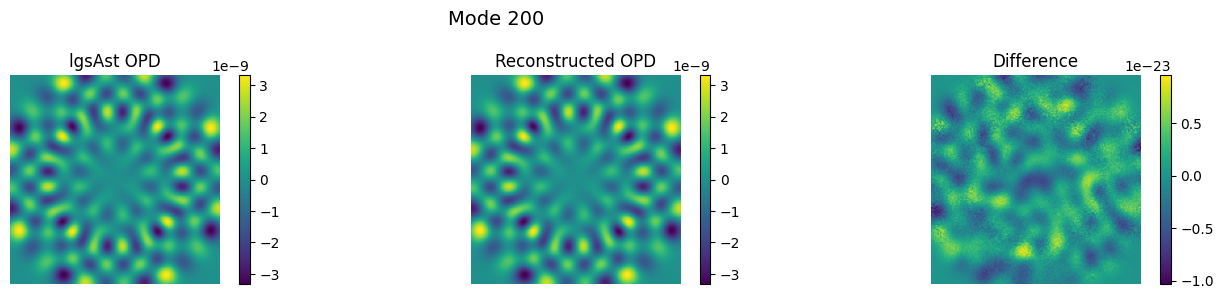

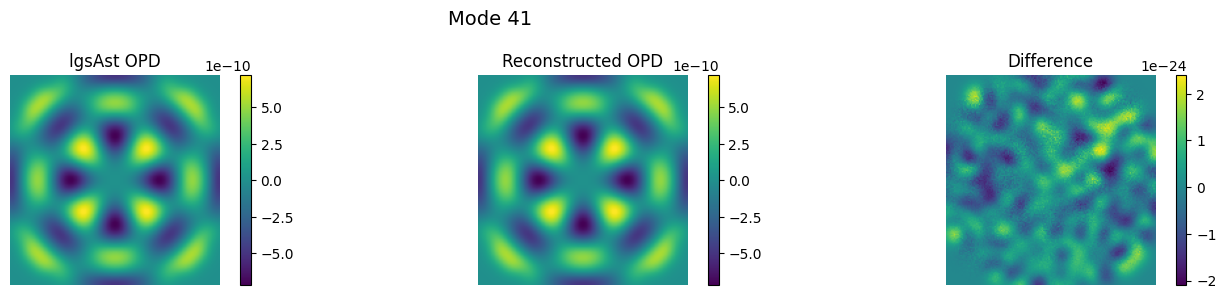

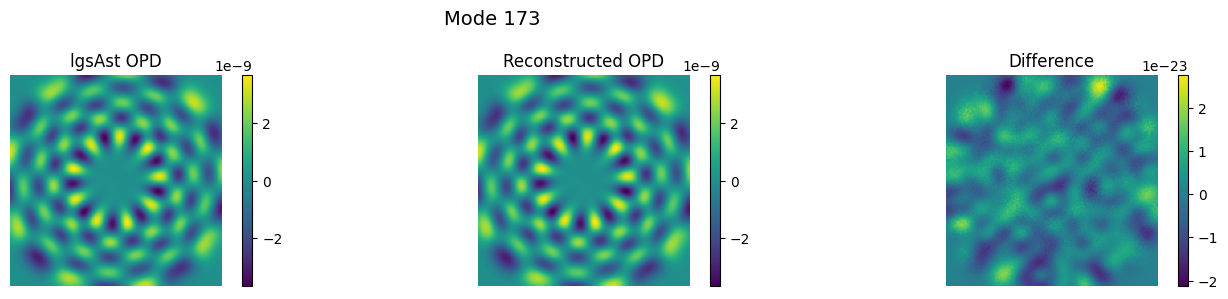

In [42]:
n_iter = 5
for i in range(n_iter):
    n = np.random.randint(M2C_KL.shape[1])
    input_modes = np.random.randn(1) * 1e-9
    dm_fried.coefs = M2C_KL[:, n] * input_modes

    ngs**tel*dm_fried*shwfs

    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(f'Mode {n}', fontsize=14)

    im = axes[0].imshow(ngs.OPD_no_pupil)
    axes[0].axis('off')
    axes[0].set_title('lgsAst OPD')
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    rec_OPD = (dm_fried.modes @ reconstructor @ shwfs.signal).reshape((tel.resolution, tel.resolution))

    im = axes[1].imshow(rec_OPD)
    axes[1].axis('off')
    axes[1].set_title('Reconstructed OPD')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    im = axes[2].imshow(dm_fried.OPD - rec_OPD)
    axes[2].axis('off')
    axes[2].set_title('Difference')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

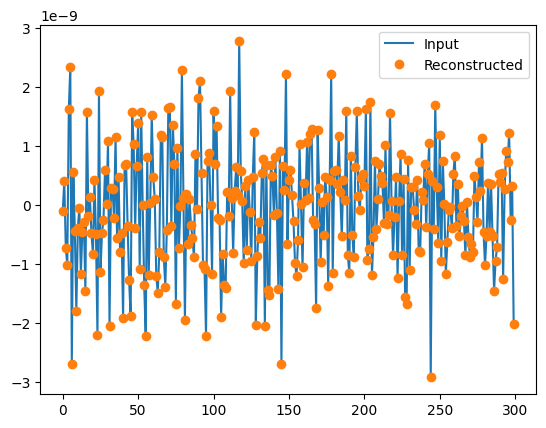

In [46]:
input_modes = np.random.randn(300)*1e-9
dm_fried.coefs = M2C_KL[:,:300]@ input_modes
ngs**tel*dm_fried*shwfs

plt.plot(input_modes,label='Input')
plt.plot(calib_modal.M@shwfs.signal,'o',label='Reconstructed')
plt.xlabel(''),plt.legend();

# Closed Loop Tutorial
This is a simple closed-loop tutorial. To get the visual simulation with a GUI, make use of the tutorials codes in a simulation environment that allows interactive display.

In [35]:
# Define a scientific source:
src = Source('K',10)
tel.resetOPD()  # initialize Telescope
dm = dm_fried
dm_fried.coefs=0      # initialize DM commands
tel.print_optical_path()


tel+atm # combine tel and atm to enable turbulence

tel.computePSF(4)

# These are the calibration data used to close the loop
calib_CL    = calib_modal
M2C_CL      = M2C_KL[:,:300]

# initialize DM commands
ngs**tel*dm*shwfs

nLoop = 200

# allocate memory to save data
SR                      = np.zeros(nLoop)
total                   = np.zeros(nLoop)
residual                = np.zeros(nLoop)
wfsSignal               = np.arange(0,shwfs.nSignal)*0

# loop parameters
gainCL                  = 0.4
display                 = True

reconstructor = M2C_CL@calib_CL.M


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  10.00  
Flux [photon/m²/s]       | 1.9e+05 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

No light propagated through the telescope
Telescope and Atmosphere combined!
Telescope and Atmosphere separated!
Telescope and Atmosphere combined!


Loop0/200 AO residual: 905.7381410376028 nm
Loop1/200 AO residual: 905.7252645533895 nm
Loop2/200 AO residual: 546.0190061689874 nm
Loop3/200 AO residual: 199.11217036767175 nm
Loop4/200 AO residual: 105.61810603205603 nm
Loop5/200 AO residual: 150.8423161833664 nm
Loop6/200 AO residual: 139.89926630313394 nm
Loop7/200 AO residual: 112.30622145083606 nm
Loop8/200 AO residual: 98.45602359799135 nm
Loop9/200 AO residual: 96.61040454353476 nm
Loop10/200 AO residual: 96.73235311104364 nm
Loop11/200 AO residual: 96.23025638056902 nm
Loop12/200 AO residual: 95.77562354051916 nm
Loop13/200 AO residual: 95.67832218197351 nm
Loop14/200 AO residual: 95.76099055062404 nm
Loop15/200 AO residual: 95.76461667271614 nm
Loop16/200 AO residual: 95.57676053813556 nm
Loop17/200 AO residual: 95.40975136203859 nm
Loop18/200 AO residual: 95.38979701110713 nm
Loop19/200 AO residual: 95.42886534998932 nm
Loop20/200 AO residual: 95.30990867811097 nm
Loop21/200 AO residual: 94.91174603752025 nm
Loop22/200 AO re

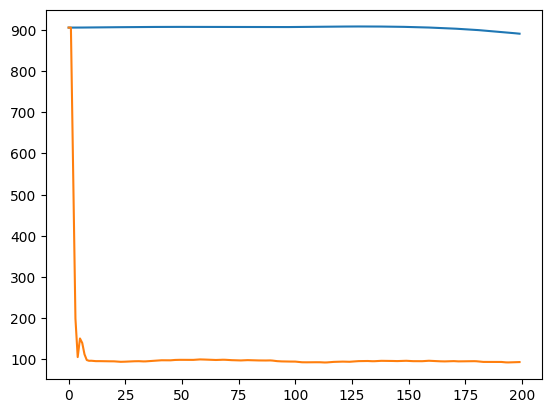

In [36]:

for i in range(nLoop):
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()

    # save phase variance
    total[i]=np.std(ngs.OPD[np.where(tel.pupil>0)])*1e9
    # save turbulent phase
    turbPhase = ngs.phase
    # propagate to the WFS with the CL commands applied
    ngs*tel*dm*shwfs

    # propagate to the source with the CL commands applied
    # src**tel*dm*shwfs

    dm.coefs=dm.coefs-gainCL*np.matmul(reconstructor,wfsSignal)
    # store the slopes after computing the commands => 2 frames delay
    wfsSignal=shwfs.signal
    # store data
    SR[i]=np.exp(-np.var(ngs.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(ngs.OPD[np.where(tel.pupil>0)])*1e9
    print('Loop'+str(i)+'/'+str(nLoop)+' AO residual: '+str(residual[i])+' nm')


# plot when done
plt.figure()
plt.plot(total)
plt.plot(residual)